In [ ]:
import nltk
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import os
!pip install indic-nlp-library
from indicnlp.tokenize import sentence_tokenize, indic_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 722.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 10.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
train_path = "/content/train_telugu_news.csv"
telugu_news_df = pd.read_csv(train_path)
telugu_news_df.head()

,SNo,date,heading,body,topic
0,414,11-05-2017 00:39:13,ఐడిబిఐపై ఆర్‌బిఐ నజర్‌,భారీ ఎత్తున మొండిబకాయిలు పెరిగిపోవడంతో ఐడిబిఐ ...,business
1,2668,12-06-2017 00:40:32,బ్యాంకింగ్‌ చీఫ్‌లతో నేడు జైట్లీ భేటీ,న్యూఢిల్లీ : ఆర్థిక మంత్రి అరుణ్‌ జైట్లీ సోమవా...,business
2,19923,19-01-2017 19:51:31,కీలక వికెట్ తీసిన జడేజా..,కటక్: ఇంగ్లండ్‌తో జరుగుతున్న సెకండ్ వన్డే మ్యా...,sports
3,15762,23-11-2017 17:29:04,మరో రెచ్చగొట్టే చర్యకు దిగిన పాకిస్థాన్,\nఇస్లామాబాద్ : పాకిస్థాన్ అంతర్జాతీయ ఉగ్రవాది...,nation
4,8624,03-04-2017 15:48:23,గోవాలో కొడుకుతో కలిసి అల్లు అర్జున్ స్విమ్మింగ్!,స్టార్‌ హీరోగా వరుస సినిమాలతో బిజీగా ఉన్నప్పటి...,entertainment


In [ ]:
telugu_news_df[telugu_news_df["heading"].isna() == True]


,SNo,date,heading,body,topic
8073,14673,20-02-2017 15:23:53,NaN,ఈ కిరాతకుడు 200 మందిని అత్యాచారం చేసి.. 500 మం...,nation


In [ ]:
topic_dic = {}

c = 0
for un in telugu_news_df["topic"].unique():
    if un not in topic_dic:
        topic_dic[un] = c
        c += 1

topic_dic

{'business': 0, 'sports': 1, 'nation': 2, 'entertainment': 3, 'editorial': 4}

In [ ]:
inv_topic_dict = {v: k for k, v in topic_dic.items()}
def func_topic(s):
    return topic_dic[s]

telugu_news_df["topic"] = telugu_news_df["topic"].apply(func_topic)
date_df = telugu_news_df["date"]
telugu_news_df["body_processed"] = telugu_news_df["body"].str.replace('\u200c', '')
telugu_news_df["body_processed"] = telugu_news_df["body_processed"].str.replace('\n', '')
telugu_news_df["body_processed"] = telugu_news_df["body_processed"].str.replace('\t', '')
telugu_news_df["body_processed"] = telugu_news_df["body_processed"].str.replace('\xa0', '')

<ipython-input-9-35baf0ff7373>:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


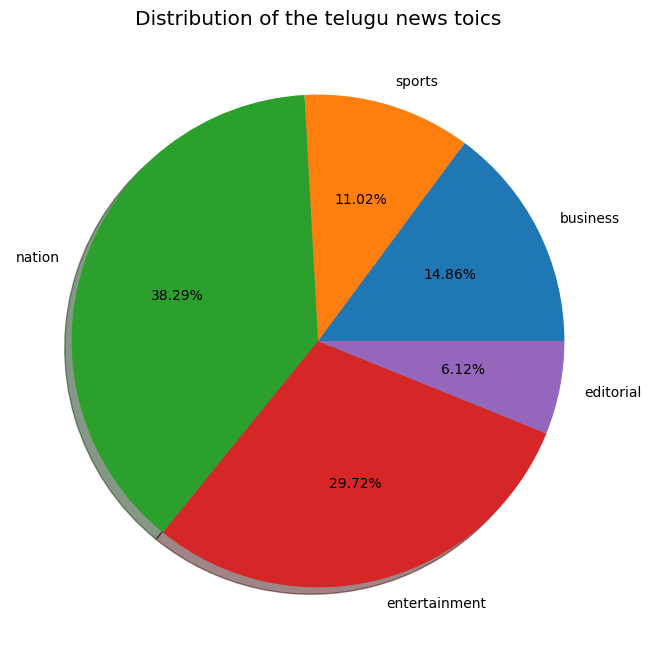

In [ ]:
def get_count(df):

    unvals = list(df.unique())
    op = [0]*len(unvals)

    i = 0
    for un in unvals:
        op[i] = df[df == un].shape[0]
        i += 1

    return [list(unvals),op]

cont = get_count(telugu_news_df["topic"])
clables = cont[0]

labels = []
for c in clables:
    labels.append(inv_topic_dict[c])

plt.figure(figsize=(10,8))
plt.title("Distribution of the telugu news toics", fontsize = 14.5)
plt.style.use('seaborn-colorblind')
plt.pie(np.array(cont[1]), labels=labels, autopct='%1.2f%%', shadow=True)
plt.show()

In [ ]:
PUNCT = string.punctuation

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT))
telugu_news_df["body_processed"] = telugu_news_df["body_processed"].apply(lambda text: remove_punctuation(text))


In [ ]:
test_path = "/content/train_telugu_news.csv"

test_news_df = pd.read_csv(test_path)

test_news_df.head()

,SNo,date,heading,body,topic
0,414,11-05-2017 00:39:13,ఐడిబిఐపై ఆర్‌బిఐ నజర్‌,భారీ ఎత్తున మొండిబకాయిలు పెరిగిపోవడంతో ఐడిబిఐ ...,business
1,2668,12-06-2017 00:40:32,బ్యాంకింగ్‌ చీఫ్‌లతో నేడు జైట్లీ భేటీ,న్యూఢిల్లీ : ఆర్థిక మంత్రి అరుణ్‌ జైట్లీ సోమవా...,business
2,19923,19-01-2017 19:51:31,కీలక వికెట్ తీసిన జడేజా..,కటక్: ఇంగ్లండ్‌తో జరుగుతున్న సెకండ్ వన్డే మ్యా...,sports
3,15762,23-11-2017 17:29:04,మరో రెచ్చగొట్టే చర్యకు దిగిన పాకిస్థాన్,\nఇస్లామాబాద్ : పాకిస్థాన్ అంతర్జాతీయ ఉగ్రవాది...,nation
4,8624,03-04-2017 15:48:23,గోవాలో కొడుకుతో కలిసి అల్లు అర్జున్ స్విమ్మింగ్!,స్టార్‌ హీరోగా వరుస సినిమాలతో బిజీగా ఉన్నప్పటి...,entertainment


In [13]:
y_test = test_news_df["topic"].apply(func_topic)
test_news_df["body_processed"] = test_news_df["body"].str.replace('\u200c', '')
test_news_df["body_processed"] = test_news_df["body_processed"].str.replace('\n', '')
test_news_df["body_processed"] = test_news_df["body_processed"].str.replace('\t', '')
test_news_df["body_processed"] = test_news_df["body_processed"].str.replace('\xa0', '')

test_news_df["body_processed"] = test_news_df["body_processed"].apply(lambda text: remove_punctuation(text))


In [14]:
categories = [i for i in range(5)]

test_text = []
for t in test_news_df["body_processed"]:
  test_text.append(t)

x_test = test_text

print(len(x_test) , len(y_test))


17312 17312


In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

categories = [i for i in range(5)]

text_topic = []
for i in range(5):
  curr_text = ""

  for text in telugu_news_df[telugu_news_df["topic"] == i]["body_processed"]:
    curr_text += text
    curr_text += " "

  text_topic.append(curr_text)

len(text_topic)

for i in range(5):
  print(len(text_topic[i]))

3303990
2092003
6725085
5737025
6077143


In [17]:
from indicnlp.tokenize import indic_tokenize


def get_all_vocab(tot_text):
  dic = {}
  for t in indic_tokenize.trivial_tokenize(tot_text):
    if t not in dic:
      dic[t] = 1
    else:
      dic[t] += 1

  return dic

tot_text = ""
for i in range(5):
  tot_text += text_topic[i]
tot_vocab = get_all_vocab(tot_text)
tot_vocab = {k: v for k, v in sorted(tot_vocab.items(), key=lambda item: item[1], reverse = True)}

print(len(tot_vocab))

316736


In [18]:
x_train = text_topic
y_train = categories
import regex
from indicnlp.tokenize import indic_tokenize

# Using custom analyser for the count vectorizer (as telugu is an indeic language)
def custom_analyzer(text):
    words = regex.findall(r'\w{1,}', text) #extract words of at least 2 letters
    for w in words:
        yield w

In [19]:
count_vec = CountVectorizer(max_df = 0.75,min_df=0.1, lowercase = False , analyzer = custom_analyzer, max_features=100000, ngram_range=(1,2))

x_train_features = count_vec.fit_transform(x_train)
x_test_features = count_vec.transform(x_test)
x_train_features.shape
len(count_vec.stop_words_)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


201776

In [20]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(x_train_features, y_train)
MultinomialNB()

print("Test score :- ", clf.score(x_test_features, y_test))


Test score :-  0.9785697781885397


In [21]:
from sklearn.metrics import classification_report

y_pred_test = clf.predict(x_test_features)
target_names = list(inv_topic_dict.values())

print(classification_report(y_test, y_pred_test, target_names=target_names))

               precision    recall  f1-score   support

     business       0.93      1.00      0.96      2572
       sports       0.99      0.99      0.99      1908
       nation       0.99      0.96      0.98      6628
entertainment       0.99      0.99      0.99      5145
    editorial       0.95      0.95      0.95      1059

     accuracy                           0.98     17312
    macro avg       0.97      0.98      0.97     17312
 weighted avg       0.98      0.98      0.98     17312



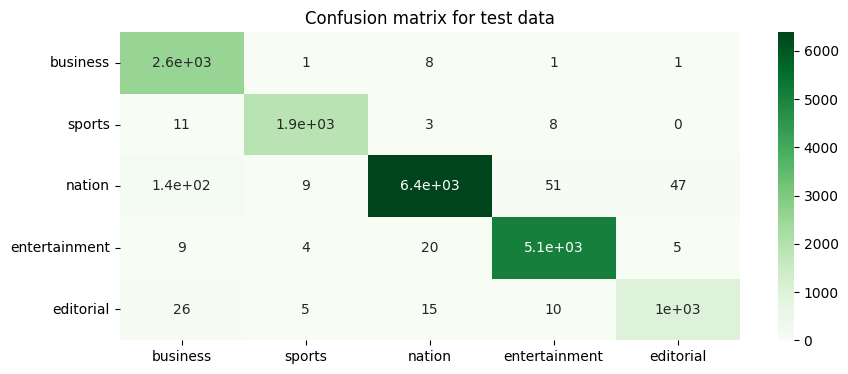

In [22]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,average_precision_score,f1_score
confusion_mat = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(10,4))
plt.title("Confusion matrix for test data")
plt.xlabel("Predicted class")
plt.ylabel("True class")

sns.heatmap(confusion_mat, annot=True, cmap="Greens",  xticklabels = target_names,
           yticklabels=target_names)
plt.show()

In [23]:
# Function for predicting a sample text with the trained model

def predict_text_sample(test_text, inv_topic_dict, clf, count_vec):
  test_sample = [test_text]
  x_test_sample_fetaures = count_vec.transform(test_sample)
  y_pred_test_sample = clf.predict(x_test_sample_fetaures)

  return inv_topic_dict[y_pred_test_sample[0]]


In [24]:
test_text ="ఇండియన్ స్క్రీన్ మీద పోటీ పడటం అయిపోయింది అందుకే ఇప్పుడు మన సినిమాలు ఫారిన్ రిలీజ్ లో పోటీ పడుతున్నాయి. ఇండియన్ సినిమాలు ముఖ్యంగా సౌత్ సినిమాలు రిలీజ్ అవుతున్నాయి అంటే వరల్డ్ వైడ్ మార్కెట్ ఓపెన్ అవుతుంది. తెలుగు తమిళ హిందీ భాషల సినిమాలు సబ్ టైటిల్స్ తో విధేశాల్లో కూడా రిలీజ్ అవుతున్నాయి"

print("Prediced class is " , predict_text_sample(test_text, inv_topic_dict, clf, count_vec))

Prediced class is  entertainment


In [25]:
test_text = "హైదరాబాద్: తెలంగాణలో సంచలనం సృష్టించిన ‘ఎమ్మెల్యేలకు ఎర’ కేసులో హైకోర్టు కీలక తీర్పు వెల్లడించింది. ఈ కేసులో ముగ్గురు నిందితుల రిమాండ్‌కు ఉన్నత న్యాయస్థానం అనుమతించింది. నిందితులు వెంటనే సైబరాబాద్ కమిషనర్‌ స్టీఫెన్‌ రవీంద్ర ఎదుట లొంగిపోవాలని ఆదేశించింది. ఒకవేళ లొంగిపోకపోతే వారిని అరెస్టు చేసి ఏసీబీ కోర్టులో హాజరుపర్చాలని.. ఆ తర్వాత రిమాండ్‌కు తరలించాలని పోలీసులను ధర్మాసనం ఆదేశించింది."
print("Prediced class is " , predict_text_sample(test_text, inv_topic_dict, clf, count_vec))

Prediced class is  nation


In [26]:
test_text = "జట్టు స్కోరు 3 పరుగుల వద్ద రెండో ఓవర్లోనే బెయిర్ స్టో అవుట్ కాగా.. ఆ తర్వాత అఫ్ఘానిస్తా్న్ బౌలర్ల ఉచ్చులో ఇంగ్లండ్ బ్యాటర్లు విలవిలలాడిపోయారు. "
print("Prediced class is " , predict_text_sample(test_text, inv_topic_dict, clf, count_vec))

Prediced class is  sports


In [27]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical

# Preprocessing
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(telugu_news_df['body'])
sequences = tokenizer.texts_to_sequences(telugu_news_df['body'])
data = pad_sequences(sequences, maxlen=200)
# Check the number of unique categories in 'topic'
num_categories = len(telugu_news_df['topic'].unique())

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=200))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(num_categories, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert labels to categorical
labels = to_categorical(telugu_news_df['topic'], num_classes=num_categories)

# Train the model
model.fit(data, labels, epochs=10, batch_size=32)

Epoch 1/10
541/541 [==============================] - 117s 199ms/step - loss: 0.5436 - accuracy: 0.8115
Epoch 2/10
541/541 [==============================] - 90s 167ms/step - loss: 0.2011 - accuracy: 0.9422
Epoch 3/10
541/541 [==============================] - 100s 185ms/step - loss: 0.1277 - accuracy: 0.9639
Epoch 4/10
541/541 [==============================] - 117s 217ms/step - loss: 0.0835 - accuracy: 0.9779
Epoch 5/10
541/541 [==============================] - 92s 171ms/step - loss: 0.0677 - accuracy: 0.9823
Epoch 6/10
541/541 [==============================] - 90s 166ms/step - loss: 0.0537 - accuracy: 0.9852
Epoch 7/10
541/541 [==============================] - 89s 164ms/step - loss: 0.0419 - accuracy: 0.9891
Epoch 8/10
541/541 [==============================] - 90s 167ms/step - loss: 0.0307 - accuracy: 0.9925
Epoch 9/10
541/541 [==============================] - 88s 163ms/step - loss: 0.0264 - accuracy: 0.9935
Epoch 10/10
541/541 [==============================] - 89s 164ms/step 

In [28]:
def predict_category(text, tokenizer, model, inv_topic_dict):
    # Preprocess the text
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=200)

    # Predict
    prediction = model.predict(padded_sequence)
    predicted_category_index = np.argmax(prediction)
    predicted_category = inv_topic_dict[predicted_category_index]

    return predicted_category

In [29]:
sample_text = "ఆగండ్రా బాబూ రేయ్ ఆగండ్రే.. అంటూ తన ఫ్యాన్స్‌ కేరింతల్ని రెట్టింపు చేస్తూ తన మాస్ మేనరిజంతో స్పీచ్ ఇచ్చారు రవితేజ. ఈ సినిమా ప్రతి బ్లాక్.. అంత అందంగా వచ్చిందంటే.. సినిమాటోగ్రాఫర్ మది.. యాక్షన్ ఎపిసోడ్ చేసిన రామ్ లక్ష్మణ్, పీటర్ హెయిన్స్. ఆ ట్రైన్ ఎపిసోడ్‌ చేసింది పీటర్ హెయిన్స్. ఈ సినిమా రియల్ క్యారెక్టర్ కాబట్టి.. రియల్ ఎమోషన్స్‌తో సినిమా చేశారు. రియల్ యాక్షన్ ఎమోషన్స్ అంత బాగా రావడానికి కారణం ఏంటంటే.. రామ్ లక్ష్మణ్‌లు కూడా.. టైగర్ నాగేశ్వరరావు ఏరియాకి చెందిన చీరాల వారే. ఈ టైగర్ నాగేశ్వరరావు గురించి బాగా తెలిసిన వాళ్లు రామ్ లక్ష్మణ్‌లు."

predicted_category = predict_category(sample_text, tokenizer, model, inv_topic_dict)
print("Predicted Category:", predicted_category)

1/1 [==============================] - 1s 1s/step
Predicted Category: entertainment


In [30]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [31]:
def generate_ngrams(tokens, n=2):
    return [' '.join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def custom_analyzer_with_ngrams(text, n=2):
    words = indic_tokenize.trivial_tokenize(text)
    ngrams = generate_ngrams(words, n)
    return words + ngrams

In [32]:
def get_recommendations_by_index(article_index, df_content, top_n=10):
    vect = TfidfVectorizer(analyzer=custom_analyzer_with_ngrams, ngram_range=(1,2), max_df=0.85, min_df=0.05)
    count_matrix = vect.fit_transform(df_content.body_processed.values)

    article_vector = count_matrix[article_index]

    cosine_sim = linear_kernel(article_vector, count_matrix).flatten()
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    similar_article_indices = [i[0] for i in sim_scores]
    scores = [i[1] for i in sim_scores]

    similar_articles = df_content['body_processed'].iloc[similar_article_indices]
    return similar_articles, scores

article_index = 0
recommended_articles, scores = get_recommendations_by_index(article_index, telugu_news_df, 10)

print("Original Article:", telugu_news_df.iloc[article_index]['body_processed'][:100], "\n")
for idx, (article, score) in enumerate(zip(recommended_articles, scores)):
    print(f"Score: {score:.4f} - Article: {article[:100]}...")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:544: UserWarning: The parameter 'ngram_range' will not be used since 'analyzer' is callable'
  warnings.warn(


Original Article: భారీ ఎత్తున మొండిబకాయిలు పెరిగిపోవడంతో ఐడిబిఐ వ్యవహారాలపై భారత రిజర్వు బ్యాంకు ఆర్బిఐ ఒక కన్నేసింది  

Score: 0.4666 - Article: చండీగఢ్ ఆర్బిఐ కొత్త రూ10 నోట్లు జారీ చేయబోతోంది మహాత్మాగాంధీ సీరిస్ 2005లో భాగంగా గవర్నర్ ఉర్జిత పట...
Score: 0.4547 - Article: గురుగ్రామ్ మణప్పురం ఫైనాన్స్ కంపెనీపై 8 మంది సాయుధులు దాడిచేసి 33 కిలోల బంగారంతో పాటు రూ8లక్షల నగదు ...
Score: 0.4514 - Article: అహ్మదాబాద్ గుజరాత్ అంతర్జాతీయ సరిహద్దుల్లోని జఖావు తీరం వద్ద 100 మందికి పైగా భారత జాలర్లను పాకిస్తాన...
Score: 0.4481 - Article: న్యూఢిల్లీ టెలికం రంగంలోకి మెరుపు వేగంతో దూసుకొచ్చిన రిలయన్స్ జియో వస్తూ వస్తూనే మొబైల్ టారిఫ్లను అమ...
Score: 0.4395 - Article: భారతీయ జనతాపార్టీ అధ్యక్షుడు అమిత్ షాను సోహ్రబుద్దీన్ ఎన్కౌంటర్ వివాదం వదిలేట్టు లేదు ఈ కేసును గతంలో...
Score: 0.4242 - Article: జిఎస్టి అమల్లోకి వస్తున్న తరుణంలో మార్కెట్లో ఔషధాల కొరతకు అవకాశం ఉందన్న హెచ్చరికలు వినవస్తున్నాయి రె...
Score: 0.4173 - Article: విలువ రూ4500 కోట్లున్యూఢిల్లీ ఇంజనీరింగ్ దిగ్గజం ఎల్ అండ్ టికి రక్షణ శాఖ నుంచి 1